# Retrieval 6: Multi-temporal parameter timeseries

:::{admonition} About this retrieval example
This example shows how to use the [rt1 python package](https://github.com/raphaelquast/rt1_model) together with [scipy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) to setup a retrieval procedure to 

- obtain multiple dynamic parameters **with different temporal frequencies** from a series of incidence-angle dependent $\sigma^0$ measurements.

> **IMPORTANT**
> Make sure to checkout **"Retrieval 3: Multi-parameter timeseries"** first!  
> This example will use the same start conditions, but `tau` values are retrieved at a **different temporal frequency** compared to `N`.

:::


In [1]:
%matplotlib widget
from rt1_model import RT1, surface, volume, set_loglevel
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import numpy as np

rand = np.random.RandomState(123456)  # initialize a reproducible random state
set_loglevel("info")

## Specify simulation and fit parameters
### Set parameter values that are used to simulate the data

In [2]:
dB, sig0 = False, True

num = 100  # Number of measurements
incs = 30  # Available incidence angles per measurement
noise_sigma = 0.5 if dB is True else 1e-3  # Noise-level (sigma of gaussian noise)

inc = rand.normal(45, 10, (num, incs)).clip(20, 70)             # Incidence angles
N = rand.normal(0.1, 0.1, (num, 1)).clip(0.01, 0.25)            # NormBRDF values
tau = (0.1 + 0.5 * np.sin(np.linspace(0, 2*np.pi, num))**2)[:,np.newaxis]   # Optical Depth values

sim_params = dict(tau=tau, omega=0.2, N=N)  # Simulation parameter values
const_params = dict(t_s=0.4)                # Constant parameters (assumed to be known)

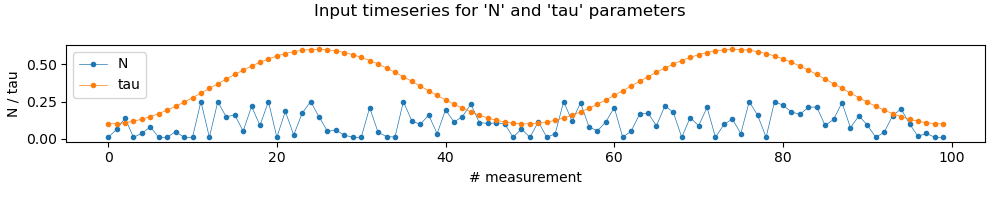

In [3]:
f, ax = plt.subplots(figsize=(10, 2))
f.canvas.header_visible = False
f.suptitle(r"Input timeseries for 'N' and 'tau' parameters")
ax.plot(N, marker=".", lw=0.5, label="N")
ax.plot(tau, marker=".", lw=0.5, label="tau")
ax.set_ylabel("N / tau")
ax.set_xlabel("# measurement")
ax.legend(loc="upper left")
f.tight_layout()

### Set start values and boundaries for the fit

:::{note}
- For the parameter `omega`, a single value is optimized for the entire timeseries.
- For the parameter `N`, a unique value is optimized for **each timestamp**.  
- For the parameter `tau` a unique value is optimized only **every `tau_freq` timestamps**!  
  (assuming that `tau` remains constant during the period)
:::

In [5]:
# set the temporal frequency at which "tau" values should be retrieved
tau_freq = 5

assert num%tau_freq==0, f"The length of the timeseries (num={num}) must be divisible by the temporal frequency of 'tau' (tau_freq={tau_freq})!"

n_tau = num // tau_freq  # number of unique tau-values with respect to the chosen frequency

start_vals = dict(omega=[0.2], tau=[0.3] * n_tau, N=[0.1] * num)
bnd_vals = dict(omega=[(0.01, 0.5)], tau=[(0.01, 1.)] * n_tau, N=[(0.01, 0.5)] * num)

## Setup RT1 and create a simulated dataset

In [4]:
V = volume.Rayleigh()
SRF = surface.HG_nadirnorm(t="t_s", ncoefs=10)

R = RT1(V=V, SRF=SRF, int_Q=True, dB=dB, sig0=sig0)
R.set_monostatic(p_0=0)
R.NormBRDF = "N"  # Use a synonym for NormBRDF parameter

R.set_geometry(t_0=np.deg2rad(inc))
tot = R.calc(**sim_params, **const_params)[0]
tot += rand.normal(0, noise_sigma, tot.shape)  # Add some random noise

21:04:52.093 INFO: Evaluating coefficients for interaction-term...
21:04:52.210 INFO: Coefficients extracted, it took 0.01376 sec.


## Setup scipy optimize to fit RT1 model to the data

Since we obtain `tau` values only every `tau_freq` timestamps, we need to distribute the obtained values to the full timeseries!


In [6]:
def parse_params(x):
    """Map 1D parameter array to dict {parameter_name: value(s)}."""
    return dict(
        omega=x[0], 
        tau=np.repeat(x[1:n_tau + 1], tau_freq)[:, np.newaxis],      # make sure to re-distribute tau to the data-index
        N=x[n_tau+1:][:, np.newaxis]
    )

def fun(x):
    """Calculate residuals."""
    R.update_params(**parse_params(x), **const_params)
    res = (R.calc()[0] - tot).ravel() # Ravel result because scipy requires 1D arrays
    return res

:::{note}
In order to obtain a representation suitable to retrieve `tau` at a reduced frequency,  we have to re-shape the jacobian accordingly!
:::

In [7]:
from scipy.sparse import block_diag, hstack

def jac(x):
    """Calculate jacobian."""
    R.update_params(**parse_params(x), **const_params)

    # obtain block-diagonal sparse jacobians for "omega" and "N".
    jac_omega = R.jacobian(param_list=["omega"], format="scipy_least_squares")
    jac_N = R.jacobian(param_list=["N"], format="scipy_least_squares")

    # re-shape jacobian for "tau" to desired retrieval frequency
    jac_tau = R.jacobian(param_list=["tau"])[0].reshape(n_tau, -1)
    jac_tau = block_diag(jac_tau.tolist(), "csr").T

    # stack jacobians
    return hstack((jac_omega, jac_tau, jac_N), "csr")


In [8]:
# Unpack start-values and boundaries as required by scipy optimize
x0 = [*start_vals["omega"], *start_vals["tau"], *start_vals["N"]]
bounds = list(zip(*[*bnd_vals["omega"], *bnd_vals["tau"], *bnd_vals["N"]]))

res = least_squares(
    fun=fun,
    x0=x0,
    bounds=bounds,
    jac=jac,
    ftol=1e-5,
    gtol=1e-5,
    xtol=1e-5,
    verbose=2,
)

# Unpack found parameters
found_params = parse_params(res.x)
# Calcuate total backscatter based on found parameters
found_tot = R.calc(**found_params, **const_params)[0]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.2617e+00                                    1.28e+00    
       1              2         6.4669e-01      2.61e+00       8.01e-01       2.92e-01    
       2              3         1.6216e-01      4.85e-01       5.50e-01       7.38e-01    
       3              4         4.6370e-02      1.16e-01       7.45e-01       2.95e-01    
       4              5         1.3024e-02      3.33e-02       2.38e-01       1.64e-01    
       5              7         1.0593e-02      2.43e-03       9.32e-02       5.28e-02    
       6              8         8.5685e-03      2.02e-03       1.85e-01       1.68e-01    
       7              9         7.5000e-03      1.07e-03       1.58e-01       1.52e-01    
       8             10         6.9025e-03      5.97e-04       8.02e-02       9.44e-02    
       9             11         6.7328e-03      1.70e-04       7.98e-02       8.44e-02    

In [9]:
from IPython.display import HTML, display
s = ["<table>",
     "<caption>Retrieved Parameters</caption>",
     "<tr><th>Parameter</th><th>Target value</th><th>Start value</th><th>Retrieved value</th><th>(Target - Retrieved)</th></tr>",
     *(f"<tr><td>{key if isinstance(val, (int, float, np.number)) else key + ' <b>(mean)</b>'} </td>"
       f"<td> {np.mean(sim_params[key]):.3f} </td>"
       f"<td>{np.mean(start_vals[key]): .3f}</td>" 
       f"<td> {np.mean(val):.3f}</td>"
       f"<td>{np.mean(val - sim_params[key]): .3f}</td></tr>" 
       for key, val in found_params.items()),
     "</table>"]
display(HTML("\n".join(s)))

Parameter,Target value,Start value,Retrieved value,(Target - Retrieved)
omega,0.200,0.200,0.207,0.007
tau (mean),0.347,0.300,0.311,-0.037
N (mean),0.108,0.100,0.101,-0.007


## Visualize Results
### Plot timeseries

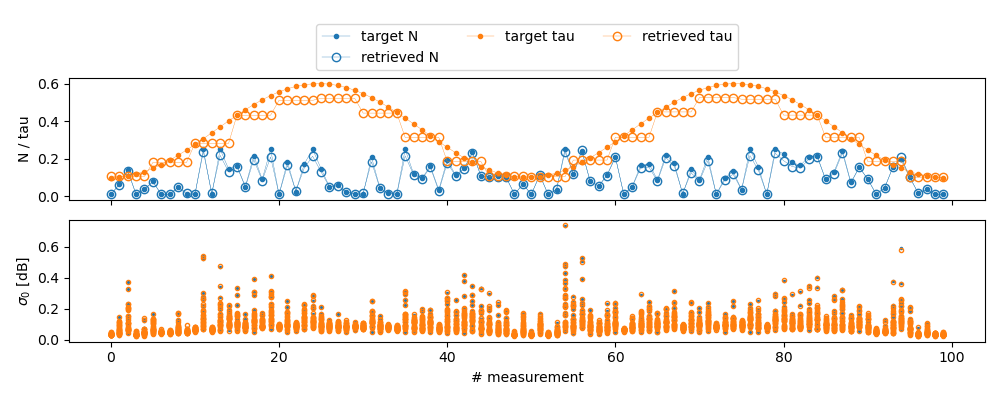

In [10]:
f, (ax, ax2) = plt.subplots(2, figsize=(10, 4), sharex=True)
f.canvas.header_visible = False

# Plot retrieved parameter timeseries
ax.set_ylabel("N / tau")

ax.plot(sim_params["N"], marker=".", lw=0.25, label="target N", c="C0")
ax.plot(found_params["N"], marker="o", lw=0.25, markerfacecolor="none", label="retrieved N", c="C0")

ax.plot(sim_params["tau"], marker=".", lw=0.25, label="target tau", c="C1")
ax.plot(found_params["tau"], marker="o", lw=0.25, markerfacecolor="none", label="retrieved tau", c="C1")

# Plot backscatter timeseries
ax2.set_ylabel(r"$\sigma_0$ [dB]")
ax2.set_xlabel("# measurement")

ax2.plot(tot, lw=0, marker=".", c="C0", ms=3)
ax2.plot(found_tot, lw=0, marker="o", markerfacecolor="none", c="C1", ms=3)

ax.legend(loc="upper center", ncols=3, bbox_to_anchor=(0.5, 1.5))
f.tight_layout()

### Initialize analyzer widget and overlay results

21:04:53.406 INFO: Evaluating coefficients for interaction-term...
21:04:53.453 INFO: Coefficients extracted, it took 0.01541 sec.


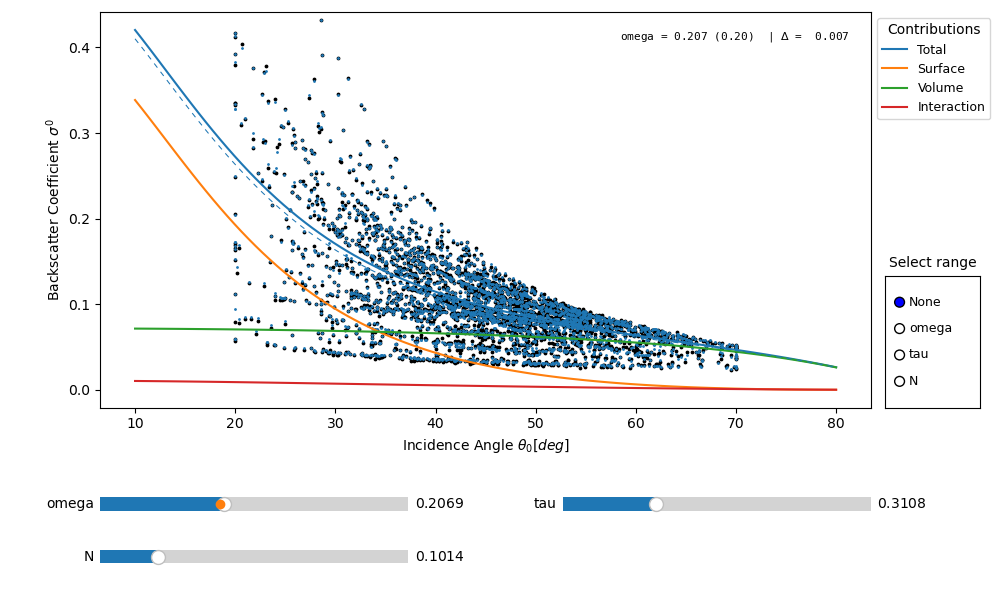

In [11]:
analyze_params = {key: (*np.mean(np.atleast_2d(bnd_vals[key]), axis=0), found_params[key].mean()) for key in found_params}

ana = R.analyze(**analyze_params)

# Plot fit-data on top
ana.ax.scatter(inc, tot, c="k", s=3, zorder=0)
ana.ax.scatter(inc, found_tot, c="C0", s=1, zorder=0)

# Indicate fit-results in slider-axes
for key, s in ana.sliders.items():
    if key in ["omega"]:
        s.ax.plot(sim_params[key], np.mean(s.ax.get_ylim()), marker="o")

# Add text for static parameters
t = ana.f.text(
    0.6,
    0.95,
    "\n".join(
        [
            f"{key:>8} = {found_params[key]:.3f} ({sim_params[key]:.2f})  "
            rf"| $\Delta$ = {found_params[key] - sim_params[key]: .3f}"
            for key in ["omega"]
        ]
    ),
    va="top",
    fontdict=dict(family="monospace", size=8),
)